In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *  
from pyspark.sql.types import *      
from pyspark.sql.window import Window
from pyspark.ml.feature import RFormula, Bucketizer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.functions import vector_to_array
from sklearn.metrics import roc_curve, auc


# Training Data 

### Paths 

In [0]:
products_path = "dbfs:/FileStore/tables/products.csv"
orders_path = "dbfs:/FileStore/tables/orders.csv"
order_reviews_path = "dbfs:/FileStore/tables/order_reviews.csv"
order_payments_path = "dbfs:/FileStore/tables/order_payments.csv"
order_items_path = "dbfs:/FileStore/tables/order_items.csv"


### Loading the Data 

In [0]:
products_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(products_path)

products_df.show(5)
products_df.describe().show()

+--------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+
|          product_id|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|product_category_name|
+--------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+
|adbcdfcfd5b8479f9...|                 49|                      1145|                 1|            2700|               20|               13|              25| agro_industry_and...|
|163a503e8aa4c48bf...|                 40|                       628|                 1|            2650|               52|               13|              32| agro_industry_and...|
|018ca97302e429305...|                 45|                       266|                 1|       

In [0]:
orders_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(orders_path)

orders_df.show(5, False)
orders_df.describe().show()

+--------------------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------------------+
|order_id                        |order_status|order_purchase_timestamp|order_approved_at  |order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|customer_id                     |
+--------------------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------------------+
|0ab7fb08086d4af9141453c91878ed7a|delivered   |2022-04-02 13:42:17     |2022-04-04 03:10:19|2022-04-04 18:11:09         |2022-04-13 20:21:08          |2022-04-18 00:00:00          |0b83f73b19c2019e182fd552c048a22c|
|cd3558a10d854487b4f907e9b326a4fc|delivered   |2021-04-12 08:35:12     |2021-04-12 08:50:12|2021-04-12 17:05:42         |2021-04-20 16:12:26

In [0]:
order_reviews_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(order_reviews_path)

order_reviews_df.show(5, False)
order_reviews_df.describe().show()

+--------------------------------+--------------------------------+------------+--------------------+-----------------------+
|review_id                       |order_id                        |review_score|review_creation_date|review_answer_timestamp|
+--------------------------------+--------------------------------+------------+--------------------+-----------------------+
|7bc2406110b926393aa56f80a40eba40|73fc7af87114b39712e6da79b0a377eb|4           |2022-01-18          |2022-01-18 21:46:59    |
|80e641a11e56f04c1ad469d5645fdfde|a548910a1c6147796b98fdf73dbeba33|5           |2022-03-10          |2022-03-11 03:05:13    |
|e64fb393e7b32834bb789ff8bb30750e|658677c97b385a9be170737859d3511b|5           |2021-04-21          |2021-04-21 22:02:06    |
|c9cfd2d5ab5911836ababae136c3a10c|cdf9aa68e72324eeb25c7de974696ee2|5           |2021-12-23          |2021-12-26 14:36:03    |
|4b49719c8a200003f700d3d986ea1a19|9d6f15f95d01e79bd1349cc208361f09|4           |2022-02-16          |2022-02-20 10:52:

In [0]:
order_payments_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(order_payments_path)

order_payments_df.show(5)
order_payments_df.describe().show()

+--------------------+------------------+------------+--------------------+-------------+
|            order_id|payment_sequential|payment_type|payment_installments|payment_value|
+--------------------+------------------+------------+--------------------+-------------+
|a9810da82917af2d9...|                 1| credit_card|                   1|         4.88|
|25e8ea4e93396b6fa...|                 1| credit_card|                   1|        13.14|
|ba78997921bbcdc13...|                 1| credit_card|                   8|        21.56|
|42fdf880ba16b47b5...|                 1| credit_card|                   2|        25.69|
|298fcdf1f73eb413e...|                 1| credit_card|                   2|        19.22|
+--------------------+------------------+------------+--------------------+-------------+
only showing top 5 rows

+-------+--------------------+------------------+------------+--------------------+------------------+
|summary|            order_id|payment_sequential|payment_type|

In [0]:
order_items_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(order_items_path)

order_items_df.show(5)
order_items_df.describe().show()

+--------------------+-------------+--------------------+-----+-------------+
|            order_id|order_item_id|          product_id|price|shipping_cost|
+--------------------+-------------+--------------------+-----+-------------+
|00010242fe8c5a6d1...|            1|4244733e06e7ecb49...|11.78|         2.66|
|00018f77f2f0320c5...|            1|e5f2d52b802189ee6...|47.98|         3.99|
|00042b26cf59d7ce6...|            1|ac6c3623068f30de0...|39.98|         3.63|
|00054e8431b9d7675...|            1|8d4f2bb7e93e6710a...| 3.98|         2.37|
|00061f2a7bc09da83...|            1|d63c1011f49d98b97...| 12.0|         1.78|
+--------------------+-------------+--------------------+-----+-------------+
only showing top 5 rows

+-------+--------------------+------------------+--------------------+-----------------+------------------+
|summary|            order_id|     order_item_id|          product_id|            price|     shipping_cost|
+-------+--------------------+------------------+--------

### Data Exploration, Cleaning and Feature Engineering

In [0]:
#Remove rows for which every column is na
products_df = products_df.na.drop("all")
orders_df = orders_df.na.drop("all")
order_items_df = order_items_df.na.drop("all")
order_payments_df = order_payments_df.na.drop("all")
order_reviews_df = order_reviews_df.na.drop("all")

# List of DataFrames to check for null counts
dataframes = {
    "products_df": products_df,
    "orders_df": orders_df,
    "order_items_df": order_items_df,
    "order_payments_df": order_payments_df,
    "order_reviews_df": order_reviews_df,
}

# Iterate and display null counts per column for each DataFrame
for name, df in dataframes.items():
    print(f"Null counts for {name}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()



Null counts for products_df:
+----------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+
|product_id|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|product_category_name|
+----------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+
|         0|                  0|                         0|                 0|               0|                0|                0|               0|                    0|
+----------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+

Null counts for orders_df:
+--------+------------+------------------------+-----------------+----------------------

In [0]:
# Products_df

# Calculate product volume
products_df = products_df.withColumn('product_vol_cm3', round(col('product_length_cm') * col('product_height_cm') * col('product_width_cm'), 2)).withColumn('product_weight_kg', col("product_weight_g") / 1000)

# Compute value counts for product_photos_qty
value_counts_df = products_df.groupBy("product_photos_qty").count().orderBy("product_photos_qty")
value_counts_df.show()


# select useful columns for product_df
products_df.select('product_id','product_category_name','product_vol_cm3','product_weight_kg').show(5)
product_tf = products_df.select('product_id','product_category_name','product_vol_cm3','product_weight_kg', "product_photos_qty")

product_tf.show(5)



+------------------+-----+
|product_photos_qty|count|
+------------------+-----+
|                 1|10405|
|                 2| 3940|
|                 3| 2484|
|                 4| 1534|
|                 5|  957|
|                 6|  644|
|                 7|  226|
|                 8|  123|
|                 9|   64|
|                10|   56|
|                11|   31|
|                12|   23|
|                13|    4|
|                14|    1|
|                15|    3|
|                17|    3|
|                18|    1|
|                19|    1|
+------------------+-----+

+--------------------+---------------------+---------------+-----------------+
|          product_id|product_category_name|product_vol_cm3|product_weight_kg|
+--------------------+---------------------+---------------+-----------------+
|adbcdfcfd5b8479f9...| agro_industry_and...|           6500|              2.7|
|163a503e8aa4c48bf...| agro_industry_and...|          21632|             2.65|
|018ca9730

In [0]:
# orders_df
orders_df.show(5)

#Filter delivered orders
orders_df = orders_df.filter(col("order_id") != "NA")
orders_df = orders_df.filter(col("order_status") == "delivered")

# Convert date columns to timestamp types for easier computations
from pyspark.sql.functions import to_timestamp

date_cols = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", 
             "order_delivered_customer_date", "order_estimated_delivery_date"]

for col_name in date_cols:
    orders_df = orders_df.withColumn(col_name, to_timestamp(col_name))

# Compute value counts for order_status
order_status_value_counts = orders_df.groupBy("order_status").count().orderBy("order_status")
order_status_value_counts.show()

# Compute derived time intervals for customer experience metrics
orders_df = orders_df.withColumn("approval_time", datediff("order_approved_at", "order_purchase_timestamp"))
orders_df = orders_df.withColumn("carrier_delivery_time", datediff("order_delivered_carrier_date", "order_approved_at"))
orders_df = orders_df.withColumn("customer_delivery_time", datediff("order_delivered_customer_date", "order_delivered_carrier_date"))
orders_df = orders_df.withColumn("delivery_delay", datediff("order_delivered_customer_date", "order_estimated_delivery_date"))
orders_df = orders_df.withColumn("delivery_days", datediff("order_delivered_customer_date", "order_purchase_timestamp"))

# Create a binary late_delivery_flag
orders_df = orders_df.withColumn("late_delivery_flag", when(col("delivery_delay") > 0, lit(1)).otherwise(lit(0)))

# Extract month, year, and season for temporal analysis

orders_df = orders_df.withColumn("purchase_month", month("order_purchase_timestamp"))
orders_df = orders_df.withColumn("purchase_year", year("order_purchase_timestamp"))

# Define seasons 
orders_df = orders_df.withColumn(
    "purchase_season",
    when(col("purchase_month").isin(12, 1, 2), "Winter")
    .when(col("purchase_month").isin(3, 4, 5), "Spring")
    .when(col("purchase_month").isin(6, 7, 8), "Summer")
    .otherwise("Fall")
)
orders_df.show(5)

orders_tf = orders_df.select("order_id", "approval_time", "carrier_delivery_time", "customer_delivery_time", "delivery_delay", "late_delivery_flag", "delivery_days","purchase_month", "purchase_year","purchase_season")
orders_tf.show(5)



+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+
|            order_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|         customer_id|
+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+
|0ab7fb08086d4af91...|   delivered|     2022-04-02 13:42:17|2022-04-04 03:10:19|         2022-04-04 18:11:09|          2022-04-13 20:21:08|          2022-04-18 00:00:00|0b83f73b19c2019e1...|
|cd3558a10d854487b...|   delivered|     2021-04-12 08:35:12|2021-04-12 08:50:12|         2021-04-12 17:05:42|          2021-04-20 16:12:26|          2021-05-04 00:00:00|104bdb7e6a6cdceaa...|
|8c3d752c5c0222787...|   delivered|     2021-

In [0]:
# Product_order_items_df

Product_order_items_df = order_items_df.join(product_tf, on ="product_id", how= "inner")
Product_order_items_df.show(5)

# Aggregation: Group by order_id to compute total_items, total_price, and total_shipping_cost, order_size, order_weight
agg_order_items_df = Product_order_items_df.groupBy("order_id").agg(count("order_item_id").alias("total_items"),
                                                                    sum("price").alias("total_price"), 
                                                                    sum("shipping_cost").alias("total_shipping_cost"), 
                                                                    sum("product_weight_kg").alias("order_weight"), 
                                                                    sum("product_vol_cm3").alias("order_size"), 
                                                                    countDistinct("product_category_name").alias("num_distinct_products_category"), 
                                                                    avg("product_photos_qty").alias("avg_photo_per_order"))

# Compute average_item_price
agg_order_items_df = agg_order_items_df.withColumn("average_item_price", expr("total_price / total_items"))

# Calculate the 90th percentile for shipping cost
shipping_cost_threshold = agg_order_items_df.approxQuantile("total_shipping_cost", [0.90], 0.05)[0]

# Create binary high_shipping_cost_flag
agg_order_items_df = agg_order_items_df.withColumn("high_shipping_cost_flag",
                                                   when(col("total_shipping_cost") > shipping_cost_threshold, lit(1)).otherwise(lit(0)))

# Categorize product_photos_qty
agg_order_items_df = agg_order_items_df.withColumn("photo_per_order_category", 
                                     when(col("avg_photo_per_order") <= 2, "Low")
                                     .when((col("avg_photo_per_order") > 2) & (col("avg_photo_per_order") <= 5), "Medium")
                                     .otherwise("High"))


agg_order_items_df.show(5)

order_items_tf = agg_order_items_df.drop("avg_photo_per_order")
order_items_tf.show(5)


+--------------------+--------------------+-------------+-----+-------------+---------------------+---------------+-----------------+------------------+
|          product_id|            order_id|order_item_id|price|shipping_cost|product_category_name|product_vol_cm3|product_weight_kg|product_photos_qty|
+--------------------+--------------------+-------------+-----+-------------+---------------------+---------------+-----------------+------------------+
|4244733e06e7ecb49...|00010242fe8c5a6d1...|            1|11.78|         2.66|           cool_stuff|           3528|             0.65|                 4|
|e5f2d52b802189ee6...|00018f77f2f0320c5...|            1|47.98|         3.99|             pet_shop|          60000|             30.0|                 2|
|ac6c3623068f30de0...|00042b26cf59d7ce6...|            1|39.98|         3.63|         garden_tools|          42000|             3.75|                 1|
|8d4f2bb7e93e6710a...|00054e8431b9d7675...|            1| 3.98|         2.37|     

In [0]:
#order_payments_df

# Remove rows with payment_installments = 0
order_payments_df = order_payments_df.filter(col("payment_installments") > 0)

# Aggregation: Group by order_id
aggregated_payments_df = order_payments_df.groupBy("order_id").agg(
    round(sum("payment_value"), 2).alias("total_payment_value"),
    countDistinct("payment_type").alias("num_payment_types"),
    max("payment_sequential").alias("num_payment_sequential"),
    max("payment_installments").alias("max_installments"),
    first("payment_type", ignorenulls=True).alias("primary_payment_type"),
    max(when(col("payment_type") == "voucher", lit(1)).otherwise(lit(0))).alias("in_voucher"),
    max(when(col("payment_type") == "credit_card", lit(1)).otherwise(lit(0))).alias("in_credit_card"),
    max(when(col("payment_type") == "mobile", lit(1)).otherwise(lit(0))).alias("in_mobile"),
    max(when(col("payment_type") == "debit_card", lit(1)).otherwise(lit(0))).alias("in_debit_card")
    )



# Categorize payment installments
aggregated_payments_df = aggregated_payments_df.withColumn(
    "installment_category", 
    when(col("max_installments") == 1, "One-Time")
    .when((col("max_installments") > 1) & (col("max_installments") <= 3), "Short-Term")
    .otherwise("Long-Term")
)

# Create binary multiple_payment_type_flag: 1 if num_payment_types > 1, else 0
aggregated_payments_df = aggregated_payments_df.withColumn(
    "multiple_payment_type_flag", 
    when(col("num_payment_types") > 1, lit(1)).otherwise(lit(0))
)

# Categorize payment complexity
aggregated_payments_df = aggregated_payments_df.withColumn(
    "payment_complexity_category",
    when(col("num_payment_sequential") == 1, "Simple")
    .when(col("num_payment_sequential").between(2, 3), "Moderate")
    .otherwise("Complex")
)

# Final selection of columns for order_payments_tf
order_payments_tf = aggregated_payments_df.select(
    "order_id", "num_payment_types", "primary_payment_type", 
    "multiple_payment_type_flag", "num_payment_sequential", 
    "total_payment_value", "max_installments", "installment_category", 
    "payment_complexity_category", "in_credit_card", "in_voucher", "in_mobile"
)

# Show the final DataFrame
order_payments_tf.show(5)

order_payments_tf.describe().show()


+--------------------+-----------------+--------------------+--------------------------+----------------------+-------------------+----------------+--------------------+---------------------------+--------------+----------+---------+
|            order_id|num_payment_types|primary_payment_type|multiple_payment_type_flag|num_payment_sequential|total_payment_value|max_installments|installment_category|payment_complexity_category|in_credit_card|in_voucher|in_mobile|
+--------------------+-----------------+--------------------+--------------------------+----------------------+-------------------+----------------+--------------------+---------------------------+--------------+----------+---------+
|00018f77f2f0320c5...|                1|         credit_card|                         0|                     1|              51.97|               3|          Short-Term|                     Simple|             1|         0|        0|
|00042b26cf59d7ce6...|                1|         credit_card|   

In [0]:
#order_reviews_df

order_reviews_df.show(5)

# Convert date columns to timestamp types
order_reviews_df = order_reviews_df.withColumn("review_creation_date", to_timestamp("review_creation_date"))
order_reviews_df = order_reviews_df.withColumn("review_answer_timestamp", to_timestamp("review_answer_timestamp"))

# Remove rows with missing review scores
order_reviews_df = order_reviews_df.filter(col("review_score").isNotNull())

# Define a window specification for the most recent review per order
window_spec = Window.partitionBy("order_id").orderBy(col("review_answer_timestamp").desc())

# Select the most recent review and its score
order_reviews_df = order_reviews_df.withColumn(
    "row_number", row_number().over(window_spec)
).filter(col("row_number") == 1).select("order_id","review_creation_date", "review_answer_timestamp", "review_score")

# Create binary target variable review_positive_flag: 1 for scores 4-5, 0 for scores 1-3
order_reviews_df = order_reviews_df.withColumn("review_positive_flag",when(col("review_score") >= 4, lit(1)).otherwise(lit(0)))

# Compute review_response_time in days
order_reviews_df = order_reviews_df.withColumn("review_response_time",datediff("review_answer_timestamp", "review_creation_date"))


# replace null values in review_response_time with average
avg_response_time = order_reviews_df.selectExpr("avg(review_response_time) as avg_time").collect()[0]["avg_time"]
order_reviews_df = order_reviews_df.fillna({"review_response_time": avg_response_time})

# select columns 
order_reviews_tf = order_reviews_df.select("order_id", "review_score", "review_positive_flag")
order_reviews_tf.show(5)



+--------------------+--------------------+------------+--------------------+-----------------------+
|           review_id|            order_id|review_score|review_creation_date|review_answer_timestamp|
+--------------------+--------------------+------------+--------------------+-----------------------+
|7bc2406110b926393...|73fc7af87114b3971...|           4|          2022-01-18|    2022-01-18 21:46:59|
|80e641a11e56f04c1...|a548910a1c6147796...|           5|          2022-03-10|    2022-03-11 03:05:13|
|e64fb393e7b32834b...|658677c97b385a9be...|           5|          2021-04-21|    2021-04-21 22:02:06|
|c9cfd2d5ab5911836...|cdf9aa68e72324eeb...|           5|          2021-12-23|    2021-12-26 14:36:03|
|4b49719c8a200003f...|9d6f15f95d01e79bd...|           4|          2022-02-16|    2022-02-20 10:52:22|
+--------------------+--------------------+------------+--------------------+-----------------------+
only showing top 5 rows

+--------------------+------------+--------------------+


### Basetable Creation

In [0]:
# Basetable_df
basetable_df = orders_tf.join(order_payments_tf, on="order_id",how='left').join(order_items_tf, on='order_id', how='inner').join(order_reviews_tf, on='order_id', how='inner')
base_df = basetable_df

# cast year as a categorical variable
base_df = base_df.withColumn("purchase_year_cat", col("purchase_year").cast("string")).drop("purchase_year", "purchase_month")

# Drop duplicates and unnecessary columns
base_df = base_df.drop("review_score", "purchase_season", "purchase_year_cat").dropDuplicates()
column_names = base_df.columns
print(column_names,len(column_names))
# "late_delivery_flag",
# Drop na values
base_df = base_df.dropna()

# Check for duplicates
duplicate_count = base_df.count() - base_df.dropDuplicates().count()
print(f"Number of duplicate rows: {duplicate_count}")

base_df.show(5)

['order_id', 'approval_time', 'carrier_delivery_time', 'customer_delivery_time', 'delivery_delay', 'late_delivery_flag', 'delivery_days', 'num_payment_types', 'primary_payment_type', 'multiple_payment_type_flag', 'num_payment_sequential', 'total_payment_value', 'max_installments', 'installment_category', 'payment_complexity_category', 'in_credit_card', 'in_voucher', 'in_mobile', 'total_items', 'total_price', 'total_shipping_cost', 'order_weight', 'order_size', 'num_distinct_products_category', 'average_item_price', 'high_shipping_cost_flag', 'photo_per_order_category', 'review_positive_flag'] 28
Number of duplicate rows: 0
+--------------------+-------------+---------------------+----------------------+--------------+------------------+-------------+-----------------+--------------------+--------------------------+----------------------+-------------------+----------------+--------------------+---------------------------+--------------+----------+---------+-----------+-----------+-----

In [0]:
# Compute null counts for each column
null_counts = base_df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in base_df.columns])

# Convert the result to a list of column names and their respective null counts
null_counts_list = [(row[col_name], col_name) for row in null_counts.collect() for col_name in row.asDict()]

print(null_counts_list)

#base_df count
base_df.count()


[(0, 'order_id'), (0, 'approval_time'), (0, 'carrier_delivery_time'), (0, 'customer_delivery_time'), (0, 'delivery_delay'), (0, 'late_delivery_flag'), (0, 'delivery_days'), (0, 'num_payment_types'), (0, 'primary_payment_type'), (0, 'multiple_payment_type_flag'), (0, 'num_payment_sequential'), (0, 'total_payment_value'), (0, 'max_installments'), (0, 'installment_category'), (0, 'payment_complexity_category'), (0, 'in_credit_card'), (0, 'in_voucher'), (0, 'in_mobile'), (0, 'total_items'), (0, 'total_price'), (0, 'total_shipping_cost'), (0, 'order_weight'), (0, 'order_size'), (0, 'num_distinct_products_category'), (0, 'average_item_price'), (0, 'high_shipping_cost_flag'), (0, 'photo_per_order_category'), (0, 'review_positive_flag')]
Out[61]: 48788

### Create Train and Validation Data for Modeling

In [0]:
#Create features and labels using Rformula

# Automatically use all columns except 'order_id' as features
formula = RFormula(formula="review_positive_flag ~ . - order_id")
final_basetable_1 = formula.fit(base_df).transform(base_df)

# Show features and label
final_basetable_1.select("features", "label").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                            |label|
+----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(31,[1,2,3,5,6,7,11,12,13,16,18,21,22,23,24,25,26,27,30],[1.0,6.0,-34.0,7.0,1.0,1.0,1.0,19.45,2.0,1.0,1.0,1.0,15.76,3.69,0.15,2048.0,1.0,15.76,1.0])|0.0  |
|(31,[1,2,3,5,6,7,11,12,13,15,16,18,21,22,23,24,25,26,27],[6.0,1.0,-6.0,7.0,1.0,1.0,1.0,17.85,7.0,1.0,1.0,1.0,1.0,15.98,1.87,1.4,15600.0,1.0,15.98]) |1.0  |
|[1.0,2.0,12.0,-3.0,0.0,15.0,1.0,1.0,0.0,0.0,0.0,1.0,26.88,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,23.96,2.92,0.56,4199.0,1.0,23.96,0.0,1.0,0.0]         |1.0  |
|(31,[1,2,3,5,6,7,11,12,13,14,16,18,21,22,23,24,25,26,27],

In [0]:
# Split into train, validation, and test sets
train_df, val_df = final_basetable_1.randomSplit([0.8, 0.2], seed=123)

# Print row counts for each dataset
print(f"Total: {final_basetable_1.count()}, Train: {train_df.count()}, Validation: {val_df.count()}")

Total: 48788, Train: 39121, Validation: 9667


# Holdout Data

Import holdout data and replicate the same transformations as on the Test data to prepare for predictions.

### Paths

In [0]:
test_products_path = "dbfs:/FileStore/test_products.csv"
test_orders_path = "dbfs:/FileStore/test_orders.csv"
test_order_items_path = "dbfs:/FileStore/test_order_items.csv"
test_order_payments_path = "dbfs:/FileStore//test_order_payments.csv"

### Loading the Data

In [0]:
#products
test_products_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(test_products_path)

products_df.show(5)
products_df.describe().show()

#orders
test_orders_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(test_orders_path)

orders_df.show(5, False)
orders_df.describe().show()

#order_payments
test_order_payments_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(test_order_payments_path)

order_payments_df.show(5)
order_payments_df.describe().show()

#order Items
test_order_items_df = spark\
.read\
.format("csv")\
.option("header","true")\
.option("inferSchema","true")\
.load(test_order_items_path)

order_items_df.show(5)
order_items_df.describe().show()

+--------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+---------------+-----------------+
|          product_id|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|product_category_name|product_vol_cm3|product_weight_kg|
+--------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+---------------+-----------------+
|adbcdfcfd5b8479f9...|                 49|                      1145|                 1|            2700|               20|               13|              25| agro_industry_and...|           6500|              2.7|
|163a503e8aa4c48bf...|                 40|                       628|                 1|            2650|               52|               13

### Data Exploration, Cleaning and Feature Engineering

In [0]:
#Remove rows for which every column is na
test_products_df = test_products_df.na.drop("all")
test_orders_df = test_orders_df.na.drop("all")
test_order_items_df = test_order_items_df.na.drop("all")
test_order_payments_df = test_order_payments_df.na.drop("all")

# List of DataFrames to check for null counts
dataframes = {
    "test_products_df": test_products_df,
    "test_orders_df": test_orders_df,
    "test_order_items_df": test_order_items_df,
    "test_order_payments_df": test_order_payments_df,
    }

# Iterate and display null counts per column for each DataFrame
for name, df in dataframes.items():
    print(f"Null counts for {name}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

Null counts for test_products_df:
+----------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+
|product_id|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|product_category_name|
+----------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+
|         0|                  0|                         0|                 0|               0|                0|                0|               0|                    0|
+----------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+---------------------+

Null counts for test_orders_df:
+--------+------------+------------------------+-----------------+------------

Treating each individual tables - Cleaning, Transformation, Feature engineering

In [0]:
# test_Products_df
# Calculate product volume
test_products_df = test_products_df.withColumn('product_vol_cm3', round(col('product_length_cm') * col('product_height_cm') * col('product_width_cm'), 2)).withColumn('product_weight_kg', col("product_weight_g") / 1000)


# select useful columns for product_df
test_products_df.select('product_id','product_category_name','product_vol_cm3','product_weight_kg').show(5)
test_product_tf = test_products_df.select('product_id','product_category_name','product_vol_cm3','product_weight_kg', "product_photos_qty")
test_product_tf.show(5)


+--------------------+---------------------+---------------+-----------------+
|          product_id|product_category_name|product_vol_cm3|product_weight_kg|
+--------------------+---------------------+---------------+-----------------+
|674005996f7500049...| agro_industry_and...|           2760|             0.65|
|b5aebb467d9a92162...| agro_industry_and...|           4096|             0.55|
|137ace556a03792cd...| agro_industry_and...|           3344|             0.55|
|eddb814fb553b6951...| agro_industry_and...|         100000|             16.7|
|f320d436d02e0ada8...| agro_industry_and...|          11900|              5.0|
+--------------------+---------------------+---------------+-----------------+
only showing top 5 rows

+--------------------+---------------------+---------------+-----------------+------------------+
|          product_id|product_category_name|product_vol_cm3|product_weight_kg|product_photos_qty|
+--------------------+---------------------+---------------+--------

In [0]:
# test_orders_df
#Filter delivered orders
test_orders_df = test_orders_df.filter(col("order_id") != "NA")
test_orders_df = test_orders_df.filter(col("order_status") == "delivered")
test_orders_df.show(5)

# Convert date columns to timestamp types for easier computations
from pyspark.sql.functions import to_timestamp

date_cols = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", 
             "order_delivered_customer_date", "order_estimated_delivery_date"]

for col_name in date_cols:
    test_orders_df = test_orders_df.withColumn(col_name, to_timestamp(col_name))

# Compute value counts for order_status
order_status_value_counts = test_orders_df.groupBy("order_status").count().orderBy("order_status")
order_status_value_counts.show()

# Compute derived time intervals for customer experience metrics
test_orders_df = test_orders_df.withColumn("approval_time", datediff("order_approved_at", "order_purchase_timestamp"))
test_orders_df = test_orders_df.withColumn("carrier_delivery_time", datediff("order_delivered_carrier_date", "order_approved_at"))
test_orders_df = test_orders_df.withColumn("customer_delivery_time", datediff("order_delivered_customer_date", "order_delivered_carrier_date"))
test_orders_df = test_orders_df.withColumn("delivery_delay", datediff("order_delivered_customer_date", "order_estimated_delivery_date"))
test_orders_df = test_orders_df.withColumn("delivery_days", datediff("order_delivered_customer_date", "order_purchase_timestamp"))

# Create a binary late_delivery_flag
test_orders_df = test_orders_df.withColumn("late_delivery_flag", when(col("delivery_delay") > 0, lit(1)).otherwise(lit(0)))

# Extract month, year, and season for temporal analysis

test_orders_df = test_orders_df.withColumn("purchase_month", month("order_purchase_timestamp"))
test_orders_df = test_orders_df.withColumn("purchase_year", year("order_purchase_timestamp"))

# Define seasons 
test_orders_df = test_orders_df.withColumn(
    "purchase_season",
    when(col("purchase_month").isin(12, 1, 2), "Winter")
    .when(col("purchase_month").isin(3, 4, 5), "Spring")
    .when(col("purchase_month").isin(6, 7, 8), "Summer")
    .otherwise("Fall")
)
test_orders_df.show(5)
test_orders_df.select("order_id", "approval_time", "carrier_delivery_time", "customer_delivery_time", "delivery_delay", "late_delivery_flag","delivery_days", "purchase_month", "purchase_year", "purchase_season").show(5)

test_orders_tf = test_orders_df.select("order_id", "approval_time", "carrier_delivery_time", "customer_delivery_time", "delivery_delay", "late_delivery_flag", "delivery_days","purchase_month", "purchase_year","purchase_season")
test_orders_tf.show(5)

+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+
|            order_id|order_status|order_purchase_timestamp|  order_approved_at|order_delivered_carrier_date|order_delivered_customer_date|order_estimated_delivery_date|         customer_id|
+--------------------+------------+------------------------+-------------------+----------------------------+-----------------------------+-----------------------------+--------------------+
|9b961b894e797f636...|   delivered|     2022-08-11 12:14:35|2022-08-11 12:25:08|         2022-08-13 14:41:00|          2022-08-20 18:18:41|          2022-09-06 00:00:00|7e0516b486e92ed3f...|
|0dbcaa88e213607d3...|   delivered|     2022-07-01 18:07:57|2022-07-01 18:30:25|         2022-07-03 14:55:00|          2022-07-07 15:47:40|          2022-07-20 00:00:00|688bb6776d5f885e4...|
|378d1ac3d8e22dd46...|   delivered|     2022-

In [0]:
# test_Product_order_items_df

test_Product_order_items_df = test_order_items_df.join(test_product_tf, on ="product_id", how= "inner")
test_Product_order_items_df.show(5)

# Aggregation: Group by order_id to compute total_items, total_price, and total_shipping_cost, order_size, order_weight
test_agg_order_items_df = test_Product_order_items_df.groupBy("order_id").agg(count("order_item_id").alias("total_items"),
                                                                    sum("price").alias("total_price"), 
                                                                    sum("shipping_cost").alias("total_shipping_cost"), 
                                                                    sum("product_weight_kg").alias("order_weight"), 
                                                                    sum("product_vol_cm3").alias("order_size"), 
                                                                    countDistinct("product_category_name").alias("num_distinct_products_category"), 
                                                                    avg("product_photos_qty").alias("avg_photo_per_order"))

# Compute average_item_price
test_agg_order_items_df = test_agg_order_items_df.withColumn("average_item_price", expr("total_price / total_items"))

# Calculate the 90th percentile for shipping cost
shipping_cost_threshold = test_agg_order_items_df.approxQuantile("total_shipping_cost", [0.90], 0.05)[0]

# Create binary high_shipping_cost_flag
test_agg_order_items_df = test_agg_order_items_df.withColumn("high_shipping_cost_flag",
                                                   when(col("total_shipping_cost") > shipping_cost_threshold, lit(1)).otherwise(lit(0)))

# Categorize product_photos_qty
test_agg_order_items_df = test_agg_order_items_df.withColumn("photo_per_order_category", 
                                     when(col("avg_photo_per_order") <= 2, "Low")
                                     .when((col("avg_photo_per_order") > 2) & (col("avg_photo_per_order") <= 5), "Medium")
                                     .otherwise("High"))


test_agg_order_items_df.show(5)
test_order_items_tf = test_agg_order_items_df.drop("avg_photo_per_order")
test_order_items_tf.show(5)

+--------------------+--------------------+-------------+-----+-------------+---------------------+---------------+-----------------+------------------+
|          product_id|            order_id|order_item_id|price|shipping_cost|product_category_name|product_vol_cm3|product_weight_kg|product_photos_qty|
+--------------------+--------------------+-------------+-----+-------------+---------------------+---------------+-----------------+------------------+
|7634da152a4610f15...|00024acbcdf0a6daa...|            1|  2.6|         2.56|            perfumery|           2400|              0.2|                 1|
|557d850972a7d6f79...|000576fe39319847c...|            1|162.0|        14.15|         garden_tools|         118125|           13.805|                 3|
|4535b0e1091c278df...|0005f50442cb953dc...|            1| 10.8|         2.28|      books_technical|           1827|             0.85|                 1|
|f177554ea93259a5b...|00063b381e2406b52...|            1|  9.0|          2.6| fash

In [0]:
#test_order_payments_df

# Remove rows with payment_installments = 0
test_order_payments_df = test_order_payments_df.filter(col("payment_installments") > 0)

# Aggregation: Group by order_id
test_aggregated_payments_df = test_order_payments_df.groupBy("order_id").agg(
    round(sum("payment_value"), 2).alias("total_payment_value"),
    countDistinct("payment_type").alias("num_payment_types"),
    max("payment_sequential").alias("num_payment_sequential"),
    max("payment_installments").alias("max_installments"),
    first("payment_type", ignorenulls=True).alias("primary_payment_type"),
    max(when(col("payment_type") == "voucher", lit(1)).otherwise(lit(0))).alias("in_voucher"),
    max(when(col("payment_type") == "credit_card", lit(1)).otherwise(lit(0))).alias("in_credit_card"),
    max(when(col("payment_type") == "mobile", lit(1)).otherwise(lit(0))).alias("in_mobile"),
    max(when(col("payment_type") == "debit_card", lit(1)).otherwise(lit(0))).alias("in_debit_card")
    )



# Categorize payment installments
test_aggregated_payments_df = test_aggregated_payments_df.withColumn(
    "installment_category", 
    when(col("max_installments") == 1, "One-Time")
    .when((col("max_installments") > 1) & (col("max_installments") <= 3), "Short-Term")
    .otherwise("Long-Term")
)

# Create binary multiple_payment_type_flag: 1 if num_payment_types > 1, else 0
test_aggregated_payments_df = test_aggregated_payments_df.withColumn(
    "multiple_payment_type_flag", 
    when(col("num_payment_types") > 1, lit(1)).otherwise(lit(0))
)

# Categorize payment complexity
test_aggregated_payments_df = test_aggregated_payments_df.withColumn(
    "payment_complexity_category",
    when(col("num_payment_sequential") == 1, "Simple")
    .when(col("num_payment_sequential").between(2, 3), "Moderate")
    .otherwise("Complex")
)

# Final selection of columns for test_order_payments_tf
test_order_payments_tf = test_aggregated_payments_df.select(
    "order_id", "num_payment_types", "primary_payment_type", 
    "multiple_payment_type_flag", "num_payment_sequential", 
    "total_payment_value", "max_installments", "installment_category", 
    "payment_complexity_category", "in_credit_card", "in_voucher", "in_mobile"
)

# Show the final DataFrame
test_order_payments_tf.show(5)

+--------------------+-----------------+--------------------+--------------------------+----------------------+-------------------+----------------+--------------------+---------------------------+--------------+----------+---------+
|            order_id|num_payment_types|primary_payment_type|multiple_payment_type_flag|num_payment_sequential|total_payment_value|max_installments|installment_category|payment_complexity_category|in_credit_card|in_voucher|in_mobile|
+--------------------+-----------------+--------------------+--------------------------+----------------------+-------------------+----------------+--------------------+---------------------------+--------------+----------+---------+
|00024acbcdf0a6daa...|                1|         credit_card|                         0|                     1|               5.16|               2|          Short-Term|                     Simple|             1|         0|        0|
|000576fe39319847c...|                1|         credit_card|   

### Basetable Creation

Join all the treated columns to create Test Basetable

In [0]:

# test_Basetable_df

test_basetable_df = test_orders_tf.join(test_order_payments_tf, on="order_id",how='left').join(test_order_items_tf, on='order_id', how='inner')

test_base_df = test_basetable_df

# cast year as a categorical variable
test_base_df = test_base_df.withColumn("purchase_year_cat", col("purchase_year").cast("string")).drop("purchase_year", "purchase_month")
test_base_df = test_base_df.withColumn("review_positive_flag", lit(0))
# Drop duplicates and irrelivant columns
test_base_df = test_base_df.drop("review_score", "purchase_season","purchase_year_cat").dropDuplicates()
test_base_df = test_base_df.dropna()

test_column_names = test_base_df.columns
print(test_column_names,len(test_column_names))

['order_id', 'approval_time', 'carrier_delivery_time', 'customer_delivery_time', 'delivery_delay', 'late_delivery_flag', 'delivery_days', 'num_payment_types', 'primary_payment_type', 'multiple_payment_type_flag', 'num_payment_sequential', 'total_payment_value', 'max_installments', 'installment_category', 'payment_complexity_category', 'in_credit_card', 'in_voucher', 'in_mobile', 'total_items', 'total_price', 'total_shipping_cost', 'order_weight', 'order_size', 'num_distinct_products_category', 'average_item_price', 'high_shipping_cost_flag', 'photo_per_order_category', 'review_positive_flag'] 28


### Create Test Data for Prediction 

In [0]:
#Create features and labels using Rformula

# Automatically use all columns except 'order_id' as features
formula = RFormula(formula="review_positive_flag ~ . - order_id")
holdout_test = formula.fit(test_base_df).transform(test_base_df)  

# Show features and label
holdout_test.select("features", "label").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                            |label|
+----------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(31,[1,2,3,5,6,7,11,12,13,16,18,21,22,23,24,25,26,27,29],[8.0,6.0,-27.0,14.0,1.0,1.0,1.0,17.77,2.0,1.0,1.0,1.0,15.0,2.77,0.167,2520.0,1.0,15.0,1.0])|0.0  |
|[0.0,1.0,5.0,-22.0,0.0,6.0,1.0,1.0,0.0,0.0,0.0,1.0,20.88,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,17.2,3.68,1.2,15750.0,1.0,17.2,0.0,0.0,1.0]            |0.0  |
|[0.0,1.0,2.0,-5.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,3.88,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2.4,1.48,0.15,12420.0,1.0,2.4,0.0,0.0,1.0]               |0.0  |
|(31,[1,2,3,5,6,7,11,12,13,16,18,21,22,23,24,25,26,27,29],

# Estimate ML Models - Logistic Regression, Random Forest and Gradient Boosting

### Crossvalidation Gradient Boosting

In [0]:
# Define pipeline
# gbt = GBTClassifier(labelCol="label", featuresCol="features")

# Set parameter grid for hyperparameter tuning
# gbtParams = ParamGridBuilder()\
  # .addGrid(gbt.maxDepth, [5, 7])\
  # .addGrid(gbt.maxIter, [20, 50])\
  # .addGrid(gbt.stepSize, [0.05, 0.1])\
  # .build()

# Define cross-validator
# gbtCv = CrossValidator()\
  # .setEstimator(gbt)\
  # .setEstimatorParamMaps(gbtParams)\
  # .setEvaluator(MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy"))\
  # .setNumFolds(2)  # 2-fold cross-validation

# Run cross-validation and choose the best set of parameters
# gbtModelCv = gbtCv.fit(train_df)

# Get the best parameters and hyperparameters
# print("Best Max Depth:", gbtModelCv.bestModel._java_obj.getMaxDepth())
# print("Best Max Iterations:", gbtModelCv.bestModel._java_obj.getMaxIter())
# print("Best Step Size:", gbtModelCv.bestModel._java_obj.getStepSize())

In [0]:
#Evaluate crossvalidation model on the validation set
# gbt_pred_cv = gbtModelCv.transform(val_df)

#Evaluate the performance of the model
# AUC = BinaryClassificationEvaluator().evaluate(gbt_pred_cv) #AUC is the default 
# print(f"AUC: {AUC}")

# Multiclass classification evaluation (Accuracy)
# accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(gbt_pred_cv)
# print(f"Accuracy: {accuracy}")

### Logistic Regression model

In [0]:
#Estimate a logistic regression model on train set
logreg_model_1 = LogisticRegression().fit(train_df)

#Predict on the validation set
logreg_pred_1 = logreg_model_1.transform(val_df)

#Evaluate the performance of the model on Validation 
Auc = BinaryClassificationEvaluator().evaluate(logreg_pred_1) #AUC is the default
print(f"Validation Auc: {Auc}")

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(logreg_pred_1)
print(f"Validation Accuracy: {accuracy}")


Validation Auc: 0.7044285320766346
Validation Accuracy: 0.814833971242371


In [0]:
#Print coefficients
print([logreg_model_1.intercept,logreg_model_1.coefficientMatrix.toArray()])


[3.787178332146201, array([[-1.45135295e-02, -3.48725832e-02, -1.73111926e-02,
        -5.57333379e-03, -1.78522447e+00, -1.94723211e-02,
         3.30089772e-02,  9.80691536e-02,  9.32189060e-02,
        -1.28871084e-02,  3.30089772e-02, -3.63062178e-02,
        -4.09639281e-02,  7.01267658e-03,  6.24968331e-02,
        -4.47238051e-02, -4.32006062e-01, -7.08182352e-01,
         8.34236864e-02,  8.76145047e-02,  9.32189060e-02,
        -4.17585390e-01,  3.71846484e-02,  6.04228730e-02,
        -5.72262504e-03, -3.70846954e-07, -1.16463003e+00,
         4.65795320e-03, -1.60668946e-01,  1.33610315e-02,
        -4.98947575e-06]])]


### Random Forest Classifier

In [0]:
#Randomforest model 

rfc_model_1 = RandomForestClassifier().fit(train_df)
#Predict on the validation set
rfc_pred_1 = rfc_model_1.transform(val_df)

#Evaluate the performance of the model
Auc = BinaryClassificationEvaluator().evaluate(rfc_pred_1) #AUC is the default
print(f"Auc: {Auc}")

# Multiclass classification evaluation (Accuracy)
accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(rfc_pred_1)
print(f"Accuracy: {accuracy}")


Auc: 0.6934219166142196
Accuracy: 0.8165925312920244


### Best model - Gradient Boosting Classifier

In [0]:

#Estimate a GBTClassifier model on train set
gbt_model_1 = GBTClassifier(
    # maxDepth=5,                
    # maxIter=70,                
    # stepSize=0.05,             
    # subsamplingRate=0.8,       "Crossvalidation hyperparameters which still resulted in a louwer auc and accuracy compared to the default settings"
    # maxBins=32,                
    # seed=42
    ).fit(train_df)

#Predict on the validation set
gbt_pred_1 = gbt_model_1.transform(val_df)

#Evaluate the performance of the model
AUC = BinaryClassificationEvaluator().evaluate(gbt_pred_1) #AUC is the default 
print(f"AUC: {AUC}")

# Multiclass classification evaluation (Accuracy)
accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(gbt_pred_1)
print(f"Accuracy: {accuracy}")



AUC: 0.7104562955318771
Accuracy: 0.8171097548360401


In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    # Extract feature metadata
    attrs = dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]
    feature_list = [attr for attr_group in attrs.values() for attr in attr_group]
    
    # Ensure feature indices are within bounds
    valid_features = [f for f in feature_list if f["idx"] < len(featureImp)]
    
    # Build DataFrame and map importance scores
    feature_importance_df = pd.DataFrame(valid_features)
    feature_importance_df["score"] = feature_importance_df["idx"].apply(lambda x: featureImp[x])
    
    return feature_importance_df.sort_values("score", ascending=False)

top_features = ExtractFeatureImp(gbt_model_1.featureImportances, train_df, "features")  
top_features.head(20)

,idx,name,score
3,3,delivery_delay,0.391310
5,5,delivery_days,0.089977
14,21,total_items,0.071143
18,25,order_size,0.062135
1,1,carrier_delivery_time,0.061527
2,2,customer_delivery_time,0.052837
16,23,total_shipping_cost,0.052361
17,24,order_weight,0.047260
20,27,average_item_price,0.035576
9,12,total_payment_value,0.026434


# Predictions

In [0]:
# Transform holdout_test data using the best model gbt_model_1

holdout_pred = gbt_model_1.transform(holdout_test)

#Create an output table with order_id and predictions
predictions = holdout_pred.select("order_id","prediction")
predictions.show(5,truncate=False)


+--------------------------------+----------+
|order_id                        |prediction|
+--------------------------------+----------+
|205fc1dde4304cae4a504a6fa594a318|1.0       |
|b804f2f3be682c81a8600da13d96951b|1.0       |
|2a400780d5bb01c0093169085cd3edbd|1.0       |
|3811f683228f7e91c35b0fd2a705af27|1.0       |
|56a88710573842db37ac692a3252a761|1.0       |
+--------------------------------+----------+
only showing top 5 rows



In [0]:
predictions.display()

order_id,prediction
205fc1dde4304cae4a504a6fa594a318,1.0
b804f2f3be682c81a8600da13d96951b,1.0
2a400780d5bb01c0093169085cd3edbd,1.0
3811f683228f7e91c35b0fd2a705af27,1.0
56a88710573842db37ac692a3252a761,1.0
994c71d451ee0dd361119399d7ade19a,1.0
c5d4547def055b1ec943673892380a0c,1.0
28fca12474d528012be6d7def6e7bc20,1.0
6f7e43972ed0a7fdbf29edf7cde6d2ad,1.0
bfc72464b974b6abff7bf44b83aab136,1.0


In [0]:
pred_value_count = predictions.groupBy("prediction").count()
pred_value_count.show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  451|
|       1.0|11978|
+----------+-----+



# Feature Importance, Confusion Matrix, ROC and Lift Curve

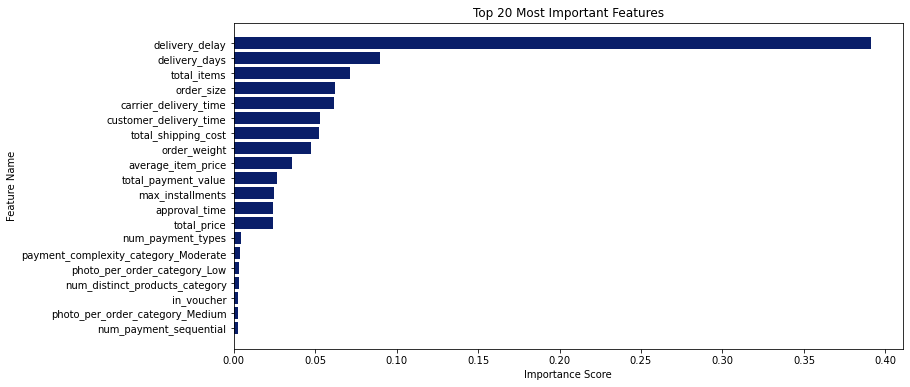

In [0]:
#Feature Importance

#Plot feature importance - Bar
plt.figure(figsize=(12, 6))
plt.barh(top_features["name"][:20], top_features["score"][:20], color="#091e69")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 20 Most Important Features")
plt.gca().invert_yaxis()
plt.show()

In [0]:
#Confusion Matrix

def confusion_matrix(pred_df):
    """
    Computes the confusion matrix for a Spark DataFrame with label & prediction columns.
    Parameters:
        pred_df (DataFrame): DataFrame with "label" and "prediction" columns.
    Returns:
        Pandas DataFrame: Confusion matrix.
    """
    cm = (pred_df
          .groupBy("label")
          .pivot("prediction")
          .count()
          .fillna(0)  # Replace missing values with 0
          .orderBy("label"))

    return cm.toPandas()

# Compute confusion matrices for validation set
print("Confusion Matrix - Validation Set")
cm_val = confusion_matrix(gbt_pred_1)
print(cm_val)



Confusion Matrix - Validation Set
   label  0.0   1.0
0    0.0  518  1628
1    1.0  140  7381


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


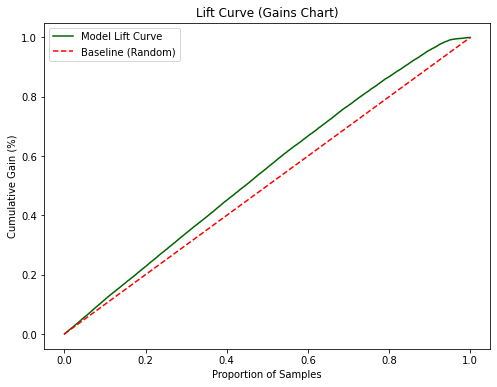

In [0]:
#Lift Curve

def plot_lift_curve(pred_df):
    """
    Plots the Lift Curve (Cumulative Gains Chart) for a PySpark DataFrame.
    Parameters:
        pred_df (DataFrame): DataFrame with "label" and "probability" columns.
    """
    # Convert to Pandas for easy plotting
    pdf = pred_df.select("label", "probability").toPandas()
    
    # Extract positive class probabilities
    pdf["probability"] = pdf["probability"].apply(lambda x: float(x[1]))  # Convert Vector to float
    
    # Sort by probability (descending)
    pdf = pdf.sort_values("probability", ascending=False).reset_index(drop=True)
    
    # Compute cumulative gain
    pdf["cumulative_positive"] = pdf["label"].cumsum()
    pdf["total_positive"] = pdf["label"].sum()
    pdf["lift"] = pdf["cumulative_positive"] / pdf["total_positive"]

    # Plot lift curve
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(pdf) + 1) / len(pdf), pdf["lift"], label="Model Lift Curve", color="darkgreen")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Baseline (Random)", color="red")
    plt.xlabel("Proportion of Samples")
    plt.ylabel("Cumulative Gain (%)")
    plt.title("Lift Curve (Gains Chart)")
    plt.legend()
    plt.show()

# Plot lift curve for validation set
plot_lift_curve(gbt_pred_1)



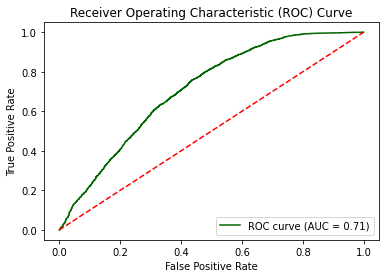

In [0]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

 
# Get the probability and label columns
roc_data = gbt_pred_1.select("probability", "label")
 
# Convert the probability vector to an array
roc_data = roc_data.withColumn("probability_array", vector_to_array(col("probability")))
 
# Collect the data into Python (this can be slow for large datasets, consider working with a subset of data if necessary)
roc_data_collected = roc_data.select("label", "probability_array").rdd.collect()
 
# Extract true labels and predicted probabilities
labels, probs = zip(*[(row['label'], row['probability_array'][1]) for row in roc_data_collected])  # Getting the probability for the positive class
 
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(labels, probs)
roc_auc = auc(fpr, tpr)
 
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkgreen', label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
 

Analysis Part

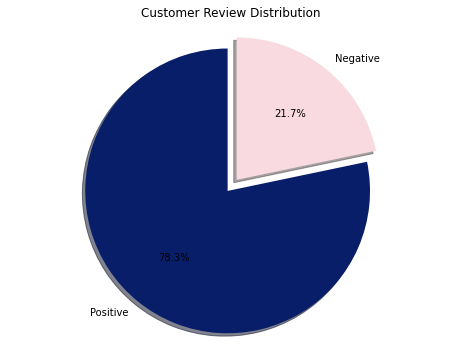

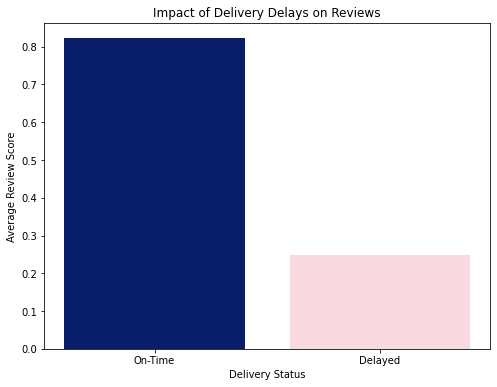

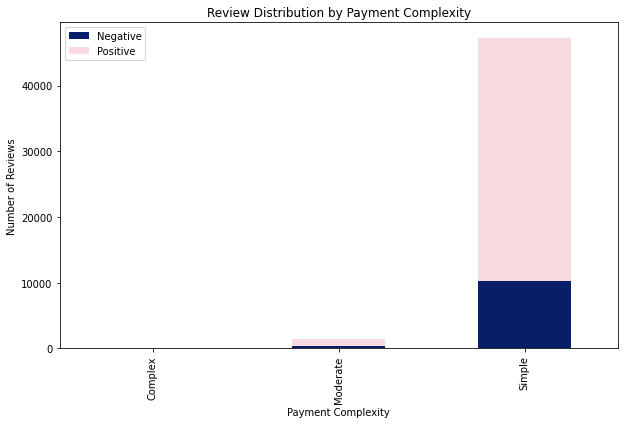

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd


# Slide 1: Data Insights Overview (Pie Chart)
review_counts = base_df.groupBy("review_positive_flag").count().collect()

positive_count = 0
negative_count = 0

for row in review_counts:
    if row["review_positive_flag"] == 1:
        positive_count = row["count"]
    elif row["review_positive_flag"] == 0:
        negative_count = row["count"]

labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
colors = ['#091e69', '#f8dae0']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Customer Review Distribution")
plt.axis('equal')
plt.savefig("review_distribution.png")
plt.show()

total_count = positive_count + negative_count
positive_percentage = (positive_count / total_count) * 100 if total_count > 0 else 0
negative_percentage = (negative_count / total_count) * 100 if total_count > 0 else 0


# Slide 2: Delivery Performance Analysis (Bar Chart)
delivery_performance = base_df.groupBy("late_delivery_flag").agg(
    avg("review_positive_flag").alias("avg_review_score")
).orderBy("late_delivery_flag").collect()

late_delivery_flags = [int(row["late_delivery_flag"]) for row in delivery_performance]
avg_review_scores = [row["avg_review_score"] for row in delivery_performance]

plt.figure(figsize=(8, 6))
plt.bar(late_delivery_flags, avg_review_scores, color=['#091e69', '#f8dae0'])  # Green for on-time, red for late
plt.xticks([0, 1], ["On-Time", "Delayed"])
plt.xlabel("Delivery Status")
plt.ylabel("Average Review Score")
plt.title("Impact of Delivery Delays on Reviews")

plt.savefig("delivery_impact.png")
plt.show()

# Slide 3: Payment Complexity Impact (Stacked Bar Chart)
payment_complexity = base_df.groupBy("payment_complexity_category", "review_positive_flag").count().orderBy("payment_complexity_category", "review_positive_flag").toPandas()

# Pivot the data for the stacked bar chart
payment_complexity = payment_complexity.pivot(index='payment_complexity_category', columns='review_positive_flag', values='count').fillna(0)
payment_complexity.columns = ['Negative', 'Positive'] # Rename columns for clarity

payment_complexity.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#091e69', '#f8dae0'])
plt.xlabel("Payment Complexity")
plt.ylabel("Number of Reviews")
plt.title("Review Distribution by Payment Complexity")

plt.savefig("payment_complexity.png")
plt.show()

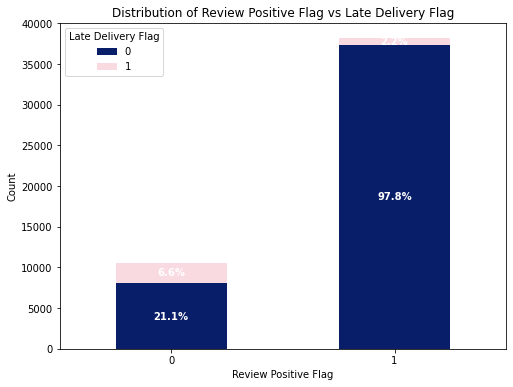

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate counts for each flag
flag_counts = base_df.groupBy("review_positive_flag", "late_delivery_flag").count().toPandas()

# Calculate percentage based on each review_positive_flag
total_counts_by_review = flag_counts.groupby("review_positive_flag")["count"].transform("sum")
flag_counts["percentage"] = (flag_counts["count"] / total_counts_by_review) * 100

# Pivot for better visualization
pivot_df = flag_counts.pivot(index="review_positive_flag", columns="late_delivery_flag", values="count").fillna(0)

# Plot
ax = pivot_df.plot(kind="bar", stacked=True, figsize=(8,6), color=['#091e69', '#f8dae0'])
plt.xlabel("Review Positive Flag")
plt.ylabel("Count")
plt.title("Distribution of Review Positive Flag vs Late Delivery Flag")
plt.xticks(rotation=0)
plt.legend(title="Late Delivery Flag")

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        review_flag = int(p.get_x() + 0.5)
        total_for_review = total_counts_by_review.iloc[review_flag]
        ax.annotate(f"{(height / total_for_review) * 100:.1f}%", 
                    (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.), 
                    ha='center', va='center', color='white', fontsize=10, weight='bold')

plt.show()

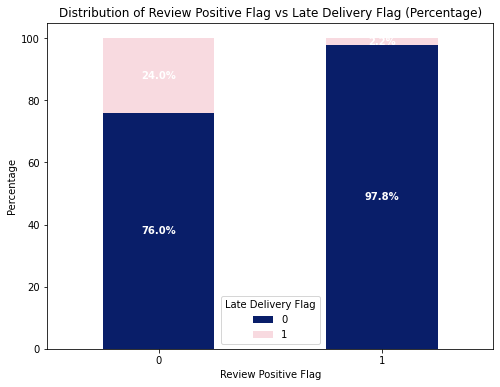

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate counts for each flag
flag_counts = base_df.groupBy("review_positive_flag", "late_delivery_flag").count().toPandas()

# Calculate percentage based on each review_positive_flag
total_counts_by_review = flag_counts.groupby("review_positive_flag")["count"].transform("sum")
flag_counts["percentage"] = (flag_counts["count"] / total_counts_by_review) * 100

# Pivot for better visualization
pivot_df = flag_counts.pivot(index="review_positive_flag", columns="late_delivery_flag", values="percentage").fillna(0)

# Plot
ax = pivot_df.plot(kind="bar", stacked=True, figsize=(8,6), color=['#091e69', '#f8dae0'])
plt.xlabel("Review Positive Flag")
plt.ylabel("Percentage")
plt.title("Distribution of Review Positive Flag vs Late Delivery Flag (Percentage)")
plt.xticks(rotation=0)
plt.legend(title="Late Delivery Flag")

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{height:.1f}%", 
                    (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.), 
                    ha='center', va='center', color='white', fontsize=10, weight='bold')

plt.show()

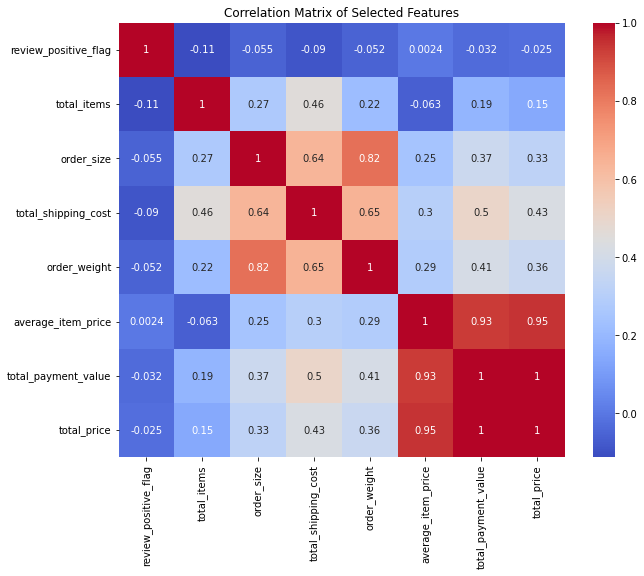

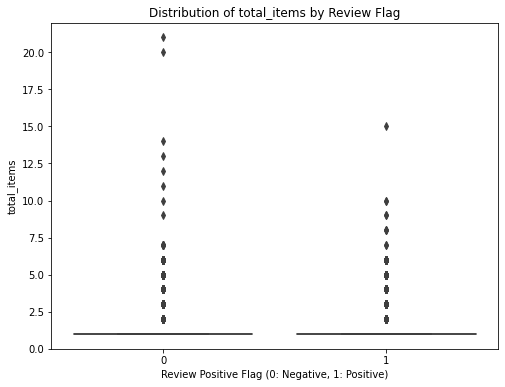

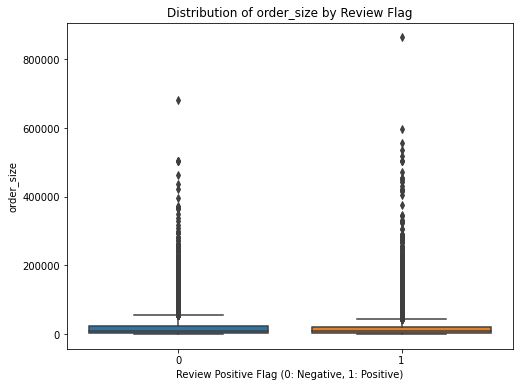

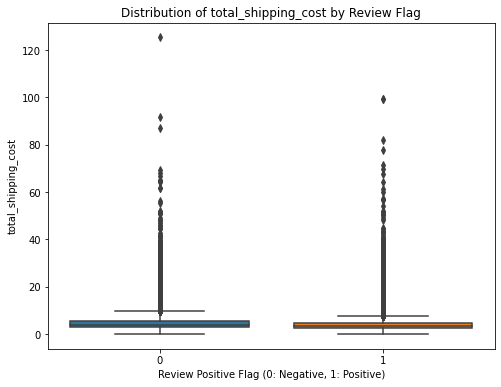

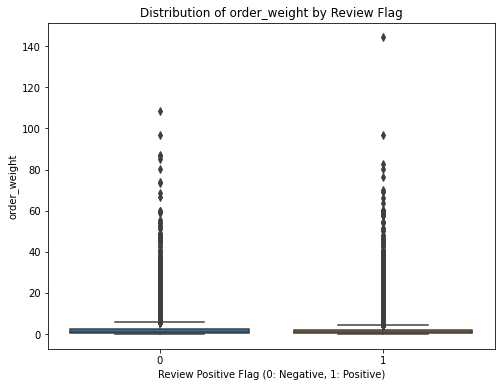

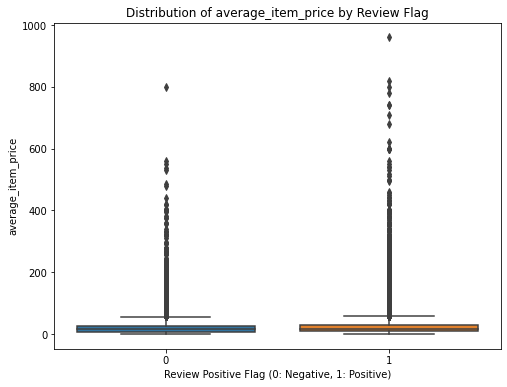

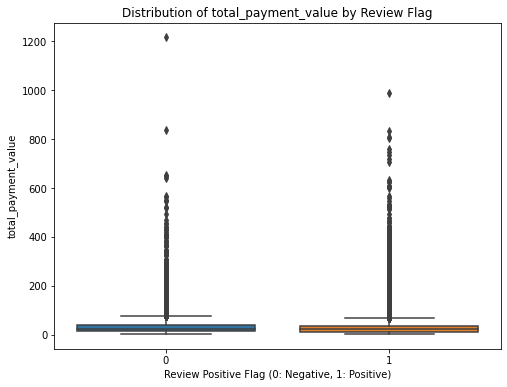

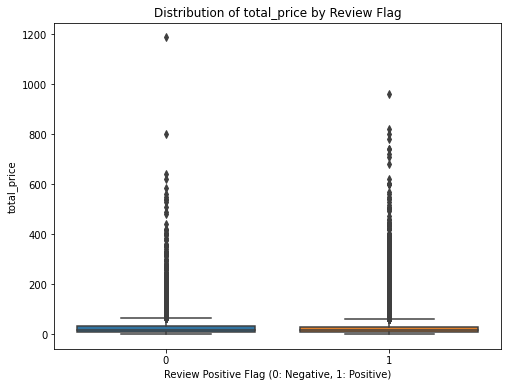

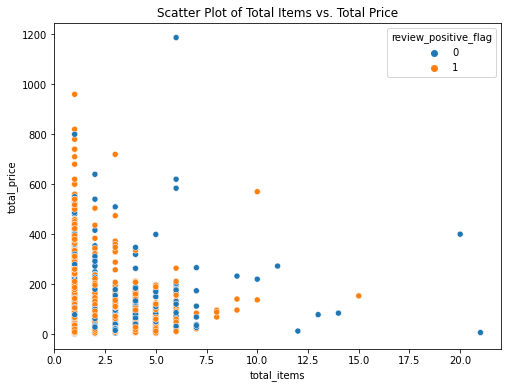

T-statistic for total_items: -24.979443406640875
P-value for total_items: 7.441486635715583e-137


In [0]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data Preparation (Filtering and Grouping)

# Select the relevant features and the target variable (assuming review_positive_flag)
analysis_df = base_df.select("review_positive_flag", "total_items", "order_size", "carrier_delivery_time", "customer_delivery_time", "total_shipping_cost", "order_weight", "average_item_price", "total_payment_value", "max_installments", "approval_time", "total_price")

# Convert to Pandas for easier plotting (after aggregations if possible)
analysis_pd = analysis_df.toPandas()


# 2. Exploratory Analysis and Visualization (Examples)

# a) Correlation Analysis (Heatmap)
import seaborn as sns
correlation_matrix = analysis_pd[["review_positive_flag", "total_items", "order_size", "total_shipping_cost", "order_weight", "average_item_price", "total_payment_value", "total_price"]].corr() # Include numeric columns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix of Selected Features")
plt.savefig("correlation_matrix.png")
plt.show()

# b) Distribution of Features by Review Flag (Box Plots or Violin Plots)

for column in ["total_items", "order_size", "total_shipping_cost", "order_weight", "average_item_price", "total_payment_value", "total_price"]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x="review_positive_flag", y=column, data=analysis_pd)
    plt.title(f"Distribution of {column} by Review Flag")
    plt.xlabel("Review Positive Flag (0: Negative, 1: Positive)")
    plt.ylabel(column)
    plt.savefig(f"{column}_distribution.png")
    plt.show()


# c) Scatter Plots (to explore relationships between features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x="total_items", y="total_price", hue="review_positive_flag", data=analysis_pd)
plt.title("Scatter Plot of Total Items vs. Total Price")
plt.savefig("total_items_vs_total_price.png")
plt.show()

# Add more scatter plots for other relevant feature combinations



# 3. Further Analysis (Examples - adapt as needed)

# a) Statistical Tests (t-tests, etc.) to compare groups (positive vs. negative reviews)
# Example:  Are total_items significantly different for positive vs. negative reviews?

from scipy.stats import ttest_ind

positive_items = analysis_pd[analysis_pd["review_positive_flag"] == 1]["total_items"]
negative_items = analysis_pd[analysis_pd["review_positive_flag"] == 0]["total_items"]

t_statistic, p_value = ttest_ind(positive_items, negative_items)
print(f"T-statistic for total_items: {t_statistic}")
print(f"P-value for total_items: {p_value}")

# Perform similar tests for other relevant features


# b)  Feature Engineering (if needed) - create new features from existing ones
# Example: Create a "price_per_item" feature

analysis_pd["price_per_item"] = analysis_pd["total_price"] / analysis_pd["total_items"]